## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.9.0.*, but conda is ignoring the .* and treating it as 1.9.0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The followin

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(6, 7):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:27<00:00, 11.49it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_6"])
layer_hs_array.shape

(10000, 267264)

## Layer 6 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

# dim_reduced_vecs = layer_hs_array

random_projector = GaussianRandomProjection(random_state = 42)
dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 7894)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 7894)
(8000,)
(2000, 7894)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 7894D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.11 s
Outer iteration 0 / 10
  Iteration 19 (0.54 s, search 0.28 s): objective=2059.95 imbalance=1.071 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (1.06 s, search 0.56 s): objective=2062.78 imbalance=1.269 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (1.58 s, search 0.83 s): objective=2059.15 imbalance=1.098 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (2.11 s, search 1.10 s): objective=2063.81 imbalance=1.211 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 10
  Iteration 19 (2.63 s, search 1.38 s): objective=2053.16 imbalance=1.497 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (3.15 s, search 1.65 s): objective=2058.6 imbalance=1.285 nsplit=0        
Outer iteration 6 / 10
  Iteration 19 (3.67 s, search 1.93 s

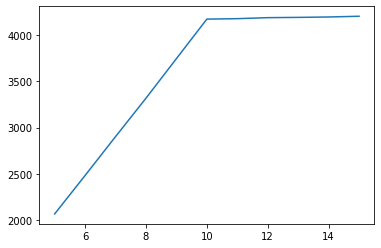

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [14]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 7894D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.04 s
Outer iteration 0 / 10
  Iteration 19 (1.06 s, search 0.56 s): objective=4150.42 imbalance=1.814 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (2.13 s, search 1.11 s): objective=4163.5 imbalance=1.190 nsplit=0        
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (3.19 s, search 1.65 s): objective=4163.56 imbalance=1.101 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 10
  Iteration 19 (4.25 s, search 2.20 s): objective=4173.94 imbalance=1.149 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 10
  Iteration 19 (5.30 s, search 2.74 s): objective=4127.65 imbalance=2.556 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (6.37 s, search 3.29 s): objective=4139.15 imbalance=1.651 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (7.42 s, search 3.84 s): obj

4174.99609375

In [15]:
kmeans.centroids #cluster centers

array([[ 0.00859791, -0.01925578,  0.01048045, ..., -0.01367696,
        -0.00169073,  0.00215992],
       [ 0.008797  , -0.01981591,  0.01198063, ..., -0.00734258,
         0.0047459 ,  0.00615032],
       [ 0.00664711, -0.01239438,  0.00690953, ..., -0.0124342 ,
         0.00660345,  0.00146987],
       ...,
       [ 0.00111436, -0.01167317,  0.0145701 , ..., -0.00728197,
        -0.00121578, -0.00597705],
       [ 0.00915883, -0.0160003 ,  0.0039775 , ..., -0.01597517,
         0.00073598,  0.00104497],
       [ 0.00788556, -0.01251784,  0.01962397, ..., -0.00155775,
         0.00780608, -0.00317753]], dtype=float32)

In [16]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.0
1.0000002
1.0000001
0.99999994
1.0000001
0.9999999
1.0
0.9999997
1.0000001
0.9999998


In [17]:
kmeans.obj #inertia at each iteration

array([2605.50244141, 3984.03295898, 4085.95043945, 4125.76123047,
       4136.50341797, 4142.21484375, 4144.82861328, 4146.09277344,
       4146.53955078, 4146.79199219, 4147.11181641, 4147.54492188,
       4148.02783203, 4148.32128906, 4148.81835938, 4149.51611328,
       4150.05126953, 4150.26269531, 4150.33740234, 4150.41699219,
       2591.56079102, 3986.59936523, 4091.78613281, 4125.54296875,
       4139.35595703, 4149.29980469, 4156.30322266, 4161.37304688,
       4162.63232422, 4162.98779297, 4163.15283203, 4163.23388672,
       4163.27539062, 4163.30712891, 4163.3359375 , 4163.36376953,
       4163.39892578, 4163.42480469, 4163.45996094, 4163.50244141,
       2515.42675781, 4000.54736328, 4095.89746094, 4128.79199219,
       4142.51708984, 4149.22216797, 4153.23144531, 4156.21044922,
       4158.62304688, 4159.91064453, 4160.80224609, 4161.42675781,
       4162.07958984, 4162.68945312, 4162.99072266, 4163.20166016,
       4163.33984375, 4163.42871094, 4163.49072266, 4163.56494

In [18]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [19]:
pd.Series(classifications_train).value_counts()

4    1368
0    1364
1    1046
5    1040
8     886
3     832
9     448
2     346
7     335
6     335
dtype: int64

In [20]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[6, 1, 9, 5, 4, 6, 10, 3, 10, 3]

In [21]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [22]:
centroid_to_label

{0: 6, 1: 1, 2: 9, 3: 5, 4: 4, 5: 6, 6: 10, 7: 3, 8: 10, 9: 3}

In [23]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 6,  9,  9, ...,  6, 10, 10])

In [24]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.3125
Prompt 2 Accuracy:  0.0
Prompt 3 Accuracy:  0.97875
Prompt 4 Accuracy:  0.3325
Prompt 5 Accuracy:  0.41625
Prompt 6 Accuracy:  0.56625
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.21625
Prompt 10 Accuracy:  0.81


In [25]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.36325


## Perform Inference on Test Set & Collect Test Accuracy

In [26]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [27]:
pd.Series(classifications_test).value_counts()

0    343
4    337
1    274
5    254
3    209
8    203
9    106
2    105
7     91
6     78
dtype: int64

In [28]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 1,  9,  6, ..., 10, 10, 10])

In [29]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.32
Prompt 2 Accuracy:  0.0
Prompt 3 Accuracy:  0.985
Prompt 4 Accuracy:  0.335
Prompt 5 Accuracy:  0.455
Prompt 6 Accuracy:  0.52
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.275
Prompt 10 Accuracy:  0.825


In [30]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.3715


## Confusion Matrix of Results

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

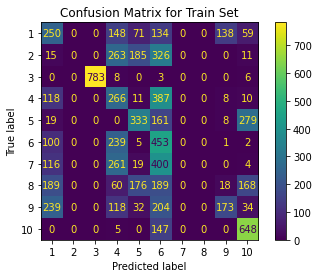

In [32]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

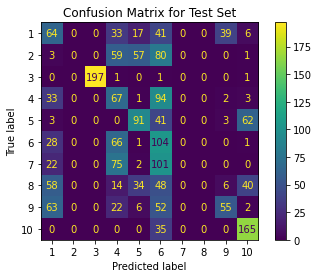

In [33]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()